In [6]:
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import AutoImageProcessor, ConvNextForImageClassification
from PIL import Image

import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch

## Integrated gradients

In [7]:
def normalize_image(img):
    img -= img.min()
    if img.max() > 0:
        img = img / img.max()
    return img

In [8]:
def visualize_ig_top3(image, ig_attributions_list, class_names, logits, alpha=0.75):
    """
    image: (H, W, 3) or (C, H, W) numpy array
    ig_attributions_list: list of 3 (C, H, W) numpy arrays, one for each top class
    class_names: list of 3 class names
    logits: list of 3 logit values
    """
    # Ensure image is (H, W, 3)
    if image.shape[0] == 3:
        image = image.transpose(1, 2, 0)
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(8, 18))
    
    for i, (ig_attr, class_name, logit) in enumerate(zip(ig_attributions_list, class_names, logits)):
        # Aggregate attributions across channels
        ig_magnitude = np.abs(ig_attr).sum(axis=0)
        
        # Normalize to [0, 1] for visualization
        ig_magnitude = (ig_magnitude - ig_magnitude.min()) / (ig_magnitude.max() - ig_magnitude.min())
        
        # Plot
        axes[i].imshow(image)
        axes[i].imshow(ig_magnitude, cmap='turbo', alpha=alpha)
        axes[i].set_title(f'{class_name}\nLogit: {logit:.2f}', fontsize=12)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [9]:
def ig(image_url, num_alphas=1, num_alpha_steps=15, model='cnn', baseline='black', flip=False):
    print(f'Using {baseline} baseline and {model} model\n')
    
    # Set device to MPS if available, otherwise CPU
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    print(f'Using device: {device}\n')
    
    # Load the model and processor
    if model.lower() == 'cnn':
        processor = AutoImageProcessor.from_pretrained('facebook/convnext-base-224')
        model = ConvNextForImageClassification.from_pretrained('facebook/convnext-base-224')
    elif model.lower() == 'vit':
        processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
        model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
    else:
        print('Valid models are "cnn" or "vit"')
        return False
    
    # Move model to device
    model = model.to(device)
    
    # Load the image
    image_np = np.array(Image.open(image_url))
    if flip:
        image_np = np.flipud(image_np)
    
    # Normalize image to [0, 1]
    image_np = normalize_image(image_np)
    
    # Convert to (C, H, W)
    image_np = image_np.transpose(2, 0, 1)
    
    # Convert to tensor
    image_tensor = torch.Tensor(image_np)
    
    # Run through processor
    image_proc = processor(images=image_tensor,
                           return_tensors='pt',
                           do_rescale=False)
    
    # Move to device
    image_proc = {k: v.to(device) for k, v in image_proc.items()}
    
    # Get image class (top 3)
    logits = model(**image_proc)[0]
    
    logits3, idx3 = logits.topk(3)
    logits3 = logits3[0]
    idx3 = idx3[0]
    
    # Print top 3 choices
    top3_classes = [(model.config.id2label[x.item()], logits3[i].item()) for i, x in enumerate(idx3)]
    print('Top 3 classes:')
    for (c, l) in top3_classes:
        print(f'{c}: {l:.2f}')
    
    # Generate baseline
    if baseline == 'black':
        baseline_np = np.zeros_like(image_np)
    elif baseline == 'white':
        baseline_np = np.ones_like(image_np)
    elif baseline == 'noise':
        baseline_np = np.random.standard_normal(image_np.shape)
        
    # Normalize baseline to [0, 1]
    baseline_np = normalize_image(baseline_np)
    
    # Store IG results for all 3 classes
    all_ig_results = []
    
    # Compute IG for each of the top 3 classes
    for class_idx, (class_name, logit_val) in enumerate(top3_classes):
        print(f'\nComputing IG for class {class_idx+1}: {class_name}')
        
        # Iterate over upper bound alphas
        alphas = np.linspace(0.01, 1, num_alphas, endpoint=True)
        alpha_ig_array = np.zeros_like(image_np)
        
        for a in tqdm(alphas, desc=f'Class {class_idx+1}'):
            # Get integral bounds for this alpha
            a_steps = np.linspace(0, a, num_alpha_steps, endpoint=True)
            
            # Generate interps
            interps = [baseline_np]
            for i in range(num_alpha_steps - 1):
                interp = baseline_np + a_steps[i] * (image_np - baseline_np)
                interps.append(interp)
            
            # Hold integrated gradients
            ig_array = np.zeros_like(interps[0])
            
            for interp_img in interps:
                # Pass through processor
                interp_img_proc = processor(images=interp_img,
                                            return_tensors='pt',
                                            do_rescale=False)
                
                # Move to device
                interp_img_proc = {k: v.to(device) for k, v in interp_img_proc.items()}
                
                # Enable gradients
                interp_img_pv = interp_img_proc['pixel_values']
                interp_img_pv.requires_grad = True
                interp_img_proc['pixel_values'] = interp_img_pv
                
                # Forward pass
                interp_img_logits = model(**interp_img_proc).logits
                
                # Grab the current class id (from top 3)
                interp_img_logits = interp_img_logits[0, idx3[class_idx]]
                
                # Backprop to calculate gradients
                interp_img_logits.backward()
                
                # Calculate gradients (integrand)
                interp_img_pv_grad = interp_img_pv.grad[0]
                
                # Accumulate gradients (move to CPU for numpy)
                ig_array += interp_img_pv_grad.cpu().numpy()
            
            # Calculate integrated gradients from equation
            ig_array = a * (image_np - baseline_np) * ig_array
            
            alpha_ig_array += ig_array
        
        # alpha_ig_array = alpha_ig_array / len(alphas)
        all_ig_results.append(alpha_ig_array)
    
    # Visualize all 3 classes
    class_names = [name for name, _ in top3_classes]
    logit_values = [logit for _, logit in top3_classes]
    visualize_ig_top3(image_np, all_ig_results, class_names, logit_values)
    
    return all_ig_results

Using black baseline and vit model

Using device: mps

Top 3 classes:
goldfish, Carassius auratus: 14.76
tench, Tinca tinca: 5.77
rock beauty, Holocanthus tricolor: 5.43

Computing IG for class 1: goldfish, Carassius auratus


Class 1:   0%|          | 0/1 [00:00<?, ?it/s]


Computing IG for class 2: tench, Tinca tinca


Class 2:   0%|          | 0/1 [00:00<?, ?it/s]


Computing IG for class 3: rock beauty, Holocanthus tricolor


Class 3:   0%|          | 0/1 [00:00<?, ?it/s]

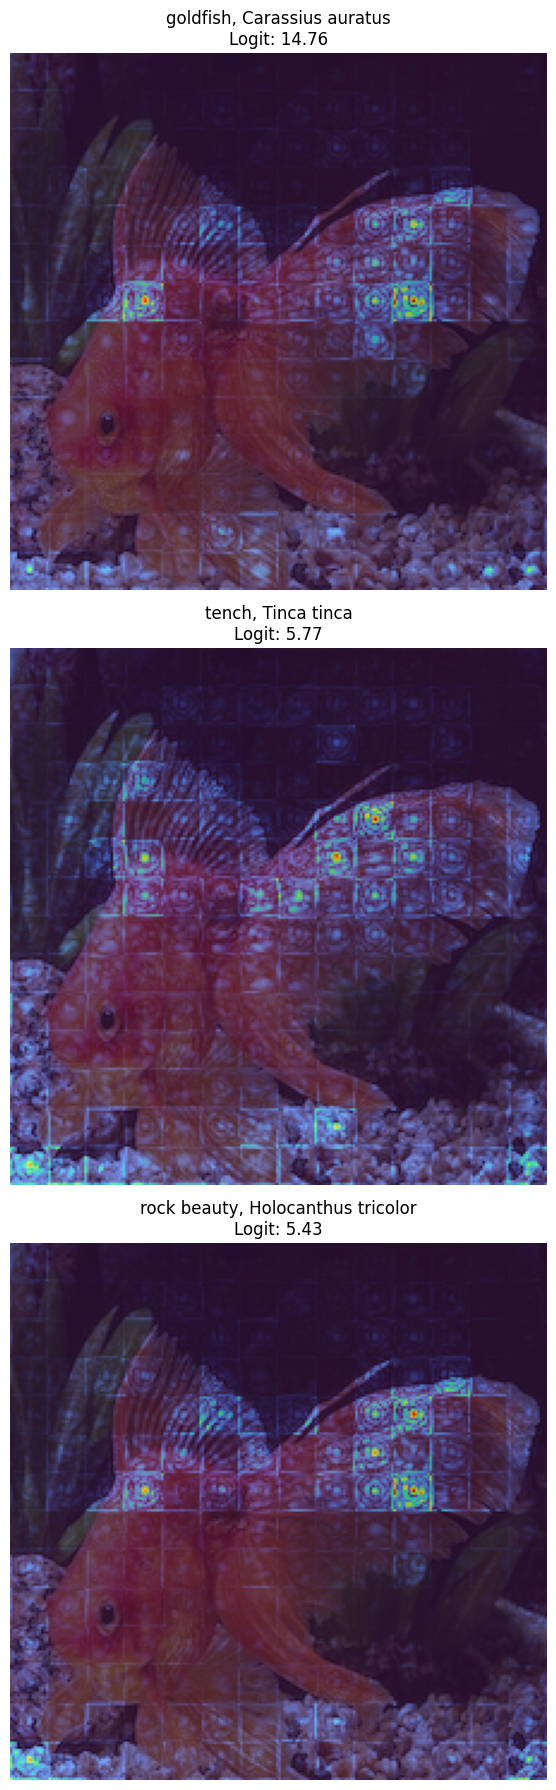

In [12]:
ig_np = ig('goldfish.jpg', model='vit')